<a href="https://colab.research.google.com/github/daniellegruber/RL-Brain-Trajectories/blob/main/Artificial_Controllable_Env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal trajectories of brain state transitions

---
# Setup

In [1]:
# @title Install dependencies
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
# Imports
import io
import os
import glob
import base64
import pdb
import sys
import math
import random
import gc

import numpy as np
from numpy import diag, matmul, reshape
from numpy.matlib import repmat

from scipy.sparse.linalg import svds
from scipy.linalg import schur
from scipy.sparse import csr_matrix, issparse
from scipy.sparse.csgraph import maximum_bipartite_matching, connected_components

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import stable_baselines3

import gym
from gym import spaces
from gym import wrappers

import torch
from torch.linalg import svdvals
from torch import unsqueeze, tensor
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import torchvision.transforms as T
import torch.nn.functional as F
import torch.distributions as distributions

from tqdm.auto import tqdm

from collections import namedtuple
from itertools import count

from typing import List, Union

from google.colab import drive

from collections import deque

from datetime import datetime

### Function to make images of matrices

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable


def mat_to_fig(mat, title, x_ax_label, x_ticks, x_labels, y_ax_label, y_ticks, y_labels):
  
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))

  # Title
  plt.title(title)
  
  # Axis labels
  if x_ax_label == 'None':
    plt.xlabel("")
  else:
    plt.xlabel(x_ax_label)
  if y_ax_label == 'None':
    plt.ylabel("")
  else:
    plt.ylabel(y_ax_label)

  # Ticks and tick labels
  if x_ticks == 'auto':
    x_ticks = np.arange(0,mat.shape[1])
    x_labels = np.arange(1,mat.shape[1] + 1)
  
  if x_ticks == 'None':
    plt.xticks([])
  else:
    plt.xticks(x_ticks, x_labels)
  
  if y_ticks == 'auto':
    y_ticks = np.arange(0,mat.shape[0])
    y_labels = np.arange(1,mat.shape[0] + 1)
  
  if y_ticks == 'None':
    plt.yticks([])
  else:
    plt.yticks(y_ticks, y_labels)

  # Check if matrix is discrete
  if mat.dtype == 'int64':
    is_discrete = True
  else:
    is_discrete = False
  
  if is_discrete:
    print('discrete!')
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    bounds = np.arange(len(np.unique(mat))+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    

    plt.imshow(mat, cmap=cmap, origin='upper')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.3)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, 
                                  spacing='proportional', ticks=bounds-0.5, boundaries=bounds, format='%1i')
    
  else:
    cmap = plt.cm.jet
    plt.imshow(mat, cmap=cmap, origin='upper')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.3)
    plt.colorbar(ax=ax,cax=cax)


### Set up directory

In [4]:
# Directory
drive.mount('/content/gdrive')
parent_dir = "gdrive/MyDrive"
child_dir = "Optimal Brain Trajectories"
save_dir = os.path.join(parent_dir, child_dir)
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
if not os.path.exists(os.path.join(save_dir,'Actor Critic')):
  os.mkdir(os.path.join(save_dir,'Actor Critic'))

save_dir = os.path.join(save_dir, 'Actor Critic')

Mounted at /content/gdrive


# Set up custom Gym environment
Some reminders about terminology and requirements:
* In `__init__`, you need to create two variables with fixed names and types.
* You need a self.action_space, and a self.observation_space.
* The reset function returns a value that is within self.observation_space. 
  * This is the function that will re-start the environment, for example, at the beginning of a game. 
* The step function has one input parameter, needs an action value, usually called action, that is within self.action_space.
* Similarly to state in the previous point, action can be an integer or a numpy.array.
  * This is the response function, the agent provides the action they want to take, and the environment returns the state it brought them to. 
* The return value is a 4-tuple, in the following order (the naming does not matter, but the variable type does):
  * state, same type of variable as the return of the reset function, of self.observation_space;
  * reward, a number that informs the agent about the immediate consequences of its action;
  * done, a boolean, value that is TRUE if the environment reached an endpoint, and should be reset, or FALSE otherwise;
  * info, a dictionary that can be used in bug fixing, and as far as I know, the baselines algorithms don’t use it.
* You need to provide these variables, but they don’t all have to have “proper“ values. For example, the info can be just an empty dictionary.
* You can have as many helping functions within your class as you want, and it doesn’t matter what you call them, as long as they don’t use any of the reserved names.


In [5]:
class BaseEnv(gym.Env):
  def __init__(self, A: np.ndarray, B: np.ndarray, init_state: np.ndarray,
               target_state: np.ndarray, rho: float, state_update_scaler: float,
               action_lim: np.ndarray, state_lim: np.ndarray):

    if torch.is_tensor(A):
      A = A.numpy()
    if torch.is_tensor(B):
      B = B.numpy()
    if torch.is_tensor(init_state):
      init_state = init_state.numpy()
    if torch.is_tensor(target_state):
      target_state = target_state.numpy()

    self.A = A
    self.B = B
    # Initial and target states
    self.init_state = init_state
    self.target_state = target_state

    # Scaling parameter for cost of control signal
    self.rho = rho
    self.state_update_scaler = state_update_scaler

    # Lower and upper bounds on actions and states, each formatted as a numpy array of shape (2,)
    self.action_lim = action_lim
    self.state_lim = state_lim

    # Initialize current state as inital state
    self.current_state = init_state

    # Number of control regions and number of all regions
    self.num_ROI = A.shape[0]
    self.num_ctrl_ROI = B.shape[1]

    # set continuous action space with dimension = # agents
    # set continuous observation space with dimension = # ROI

    self.action_space = gym.spaces.Box(
        low=action_lim[0], high=action_lim[1], shape = (self.num_ctrl_ROI,), dtype=np.float32)
    self.observation_space = gym.spaces.Box(
        low=state_lim[0], high=state_lim[1], shape = (self.num_ROI,), dtype=np.float32)

  def _compute_reward(self, *reward_args): 
    raise NotImplementedError

  def _compute_penalty(self, *penalty_args):
    raise NotImplementedError

  def _reward_function(self, reward_args: List, penalty_args: List): 
    return self._compute_reward(*reward_args) - self._compute_penalty(*penalty_args)

  def _transition_state(self, *args): 
    raise NotImplementedError

  def step(self, action):
    self.current_state = self._transition_state(self.current_state, action)
    
    # cost is difference between current state and target state plus a term 
    # penalizing the use of high-magnitude signals/actions
    reward = self._reward_function([self.current_state], [action])

    thresh = 0.01
    #done = np.linalg.norm(self.current_state - self.target_state) < thresh
    done = all(abs(self.current_state - self.target_state)) < thresh
    
    info = {}
    return self.current_state, reward, done, info

  def reset(self):
    self.current_state = self.init_state
    return self.current_state

In [6]:
class CustomEnv(BaseEnv):

  def _compute_reward(self, *reward_args): 
    return 0

  def _compute_penalty(self, action): 
    state_cost = np.linalg.norm(self.target_state - self.current_state)
    action_cost = self.rho * np.linalg.norm(action)
    return state_cost + action_cost

  def _transition_state(self, state, action):
    transition_state = self.state_update_scaler * self.A @ state + self.B @ action
    
    # Enforce bounds
    transition_state = np.clip(transition_state, 
      min(self.observation_space.low), max(self.observation_space.high))

    return transition_state

# Set up toy model parameters
Manually set up A, B, initial states, target states, and rho for toy model 

In [7]:
datestr = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

#pre_load_dir = '' # Leave empty if you want to choose randomly
pre_load_dir = '' # Or put name of directory you want to load params from
if pre_load_dir:
  pre_load = True
  save_dir = pre_load_dir
else:
  pre_load = False
  save_dir = os.path.join(save_dir, datestr)
  os.mkdir(save_dir)

save_dir_specific = os.path.join(save_dir, datestr)
os.mkdir(save_dir_specific)

## Create controllable environment


## Creating controllable env

The code below is adapted from [Leitold et al. (2019)](https://github.com/abonyilab/NOCAD).

In [8]:
def  maximumMatching(adj):
  #MATCHING calculates maximum matching and returns with the set of the matched
  #nodes, the set of the unmatched nodes and the matching itself (the i. node
  #matched by the i. element of matchedBy)
  # ##################
  # Example:
  # ##################
  # Input: 
  #
  # A=[0 1 0 0;0 0 1 0;1 0 0 1;0 0 0 0];  % could be sparse
  # ##################
  # Function Calling:
  #
  # [matched, unmatched, matchedBy]=maximumMatching(A)
  # ##################
  # Outputs:
  #
  # matched =
  #      1     2     3
  # unmatched =
  #      4
  # matchedBy =
  #      3     1     2     0
  # ##################
  #  The algorithm was implemented by Daniel Leitold 
  
  # matching
  A = csr_matrix(adj)
  matchedBy = maximum_bipartite_matching(A, perm_type='row')

  # matched nodes
  matched = np.where(matchedBy != -1)[0]
  
  # unmatched nodes
  unmatched = np.where(matchedBy == -1)[0]

  return matched, unmatched, matchedBy

# check
# A = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], [0, 0, 0, 0]])
# matched, unmatched, matchedBy = maximumMatching(A)
# print(matched, unmatched, matchedBy)

In [9]:
def maximumMatchingPF(adj):
  #MAXIMUMMATCHINGPF calculates the maximum matching and then corrects
  # it for controllability and observability. If there is an unmatched SCC,
  # then it will controlled by an input signal such that, if there is an edge
  # from the SCC to an unmatched node, then the unmatched node will be 
  # matched by the SCC. The function returns with matched, unmatched and 
  # matchedBy vector, where the i. node matched by the i. element of 
  # matchedBy. The fourth output is removable, which is a sparse matrix,
  # containing the edges, which can remove from the original network (A) to
  # provide a suitable matching for system's controllability, observability. 
  # ##################
  # Example:
  # ##################
  # Input: 
  #
  # A=[0 1 0 0;0 0 1 0;1 0 0 1;0 0 0 0];   % could be sparse
  # ##################
  # Function Calling:
  #
  # [matched, unmatched, matchedBy, removable]=maximumMatchingPF(A)
  # ##################
  # Outputs:
  #
  # matched =
  #      2     3     4
  # unmatched =
  #      1
  # matchedBy =
  #      0     1     2     3
  # removable =
  #    (3,1)        1
  # ##################
  #  The algorithm was implemented by Daniel Leitold 
  # execute maximum matching

  _ , _ , matchedBy = maximumMatching(adj)
  # correct some matching value because of SCC
  # find SCCs

  A = csr_matrix(adj)
  numOfID, compID = connected_components(A, directed=True, connection = 'strong')

  # find the components with more than one node
  comps = compID[np.where(numOfID > 1)];

  # add selfloops to comps
  # loops
  loops = np.where(csr_matrix.diagonal(A) != 0)

  # add loops' component ID
  comps = np.union1d(comps, compID[loops])

  # declare removable edges
  numOfNodes = len(matchedBy)
  removable = csr_matrix((numOfNodes, numOfNodes))

  # check the SCCs
  A = A.toarray()
  for ID in np.unique(comps):
      actualNodes = np.where(compID == ID)[0]

      # start nodes to SCC
      incoming = np.setdiff1d(np.where(np.sum(A[:,actualNodes], 1) != 0), actualNodes)
      if len(np.intersect1d(matchedBy[actualNodes], -1)) != 0:
          incoming = np.append(incoming, 0)

      # target nodes from SCC
      outgoing = np.setdiff1d(np.where(sum(A[actualNodes,:],1) != 0), actualNodes)
      
      # type of SCC
      SCC_type= 1 * (len(incoming) == 0) + 2 * (len(outgoing) == 0)
      
      if SCC_type == 0:
        # incoming and outgoing node too
        # no intervention needed
        pass

      elif SCC_type == 1:

          # no incoming some outgoing node
          if(len(np.intersect1d(matchedBy[outgoing], actualNodes)) == 0):
                  
            # uncontrolled outgoing nodes
            uncontrolled = np.intersect1d(outgoing, np.where(matchedBy == -1));
            
            # if we have to intervene
            if(len(uncontrolled) != 0):
                possibleDriverNodes = np.intersect1d(actualNodes, np.where(A[:,uncontrolled[0]] != 0))

                if(len(possibleDriverNodes) == 0):
                    matchedBy[actualNodes[0]] = -1
                
                else:
                    # add removable edge
                    toNodes = np.where(matchedBy == possibleDriverNodes[0])[0];
                    fromNodes = matchedBy[toNodes]
                    removable[fromNodes, toNodes] = 1
                    # change matching
                    matchedBy[toNodes] = -1
                    matchedBy[uncontrolled[0]] = possibleDriverNodes[0]

            else:
                # if all outgoing node controlled than only one driver
                # node necessary
                fromNodes = matchedBy[actualNodes[0]]
                removable[fromNodes, actualNodes[0]] = 1
                matchedBy[actualNodes[0]] = -1

          else:
              # the SCC controll a node, no intervention needed, only
              # one driver node necessary
              fromNodes = matchedBy[actualNodes[0]]
              removable[fromNodes, actualNodes[0]] = 1
              matchedBy[actualNodes[0]] = -1

      elif SCC_type == 2:
          # some incoming no outgoing node
          # no intervention needed 
          pass

      elif SCC_type == 3:
          # no incoming no outgoing node
          # one driver node needed
          fromNodes = matchedBy[actualNodes[0]]
          removable[fromNodes, actualNodes[0]] = 1
          matchedBy[actualNodes[0]] = -1

  # set output
  matched = np.where(matchedBy != -1)[0]
  unmatched = np.where(matchedBy == -1)[0]

  return matched, unmatched, matchedBy, removable

# check
# A = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], [0, 0, 0, 0]])
# matched, unmatched, matchedBy, removable = maximumMatchingPF( A )
# print(matched, unmatched, matchedBy, removable)

In [10]:
def generateMatricesPF(adj): 
  # GENERATEMATRICESPF generates B and C matrices of state-space model
  # from A matrix. To generate matrices generateMatricesPF uses the
  # maximumMatchingPF algorithm, so the unmatched SCCs will be 
  # resolved by path finding.
  # ##################
  # Example:
  # ##################
  # Input: 
  #
  # A=[0 1 0 0; 0 0 1 0; 1 0 0 1; 0 0 0 0];     # could be sparse
  # ##################
  # Function Calling:
  #
  # [A, B, C, D]=generateMatricesPF(A)
  # ##################
  # Outputs:
  #
  # A =
  #      0     0     1     0
  #      1     0     0     0
  #      0     1     0     0
  #      0     0     1     0
  # 
  # B =
  #      1
  #      0
  #      0
  #      0
  # 
  # C =
  #      0     0     0     1
  # 
  # D =
  #      0
  # ##################
  #  The algorithm was implemented by Daniel Leitold 
  
  # Observe
  # generate sensor nodes
  # execute maximum matching with path finding
  A = adj.transpose()
  _, unmatched, _, _ = maximumMatchingPF(A)
  
  # set sensor nodes
  sensorNodes = unmatched
  
  # define C matrix
  C = csr_matrix(([1] * len(sensorNodes), (np.arange(len(sensorNodes)), sensorNodes)), 
                       shape=(len(sensorNodes), len(A)))
  
  # Control
  # generate driver nodes
  # transpose the A matrix
  # execute maximum matching with path finding
  _, unmatched, _, _ = maximumMatchingPF(A.transpose())
  
  # set driver nodes
  driverNodes = unmatched
  
  # define B matrix
  B = csr_matrix(([1] * len(driverNodes), (driverNodes, np.arange(len(driverNodes)))), 
                       (len(A), len(driverNodes)))
  
  # define D matrix
  D = csr_matrix((len(sensorNodes), len(driverNodes)))
  if not issparse(A):
      B = B.toarray();
      C = C.toarray();
      D = D.toarray();

  return A, B, C, D 

# check
# A = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], [0, 0, 0, 0]])
# A, B, C, D = generateMatricesPF(A)
# print(A, B, C, D)

In [11]:
def is_controllable(A, B):
  num_ROI = A.shape[0]
  num_ctrl_ROI = B.shape[1]
  control_matrix = np.zeros((num_ROI, num_ROI * num_ctrl_ROI))
  for n in range (0, num_ROI):
    idx = np.arange(n*num_ctrl_ROI, (n+1)*num_ctrl_ROI)
    control_matrix[:,np.squeeze(idx)] = np.squeeze(np.linalg.matrix_power(A, n) @ B)

  rank = np.linalg.matrix_rank(control_matrix)
  if rank == num_ROI:
    print('System controllable!')
  else:
    raise ValueError('System not controllable')

### Generate adjacency matrix A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


discrete!


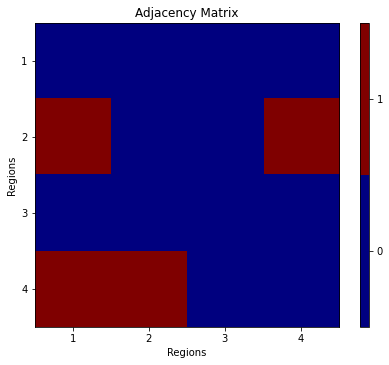

In [12]:
if pre_load:
  B = np.load(os.path.join(save_dir, 'B.npy'))
  ctrl_ROI = np.load(os.path.join(save_dir, 'ctrl_ROI.npy'))
  num_ctrl_ROI = len(ctrl_ROI)

  A = np.load(os.path.join(save_dir, 'A.npy'))
  num_ROI = A.shape[0]
  adj = A.transpose()

  mat_to_fig(A, 'Matrix A', 'Regions', np.arange(0,num_ROI), np.arange(1,num_ROI+1),
           'Regions', np.arange(0,num_ROI), np.arange(1,num_ROI+1))

  mat_to_fig(B, 'Matrix B', 'Control Regions', np.arange(0,num_ctrl_ROI), np.array(ctrl_ROI)+1,
           'None', 'None', 'None')
else:
  discrete_A = True
  num_ROI = 4
  
  if discrete_A:
    p = 0.35
    adj = np.random.binomial(1, p, (num_ROI, num_ROI))
    adj = adj.astype(int)
  else:
    adj = np.random.uniform(0, 1,(num_ROI, num_ROI))

  mat_to_fig(adj, 'Adjacency Matrix', 'Regions', np.arange(0,num_ROI), np.arange(1,num_ROI+1),
           'Regions', np.arange(0,num_ROI), np.arange(1,num_ROI+1))


In [13]:
A, B, _, _ = generateMatricesPF(adj)
num_ctrl_ROI = B.shape[1]
ctrl_ROI = np.where(B == 1)[0]

is_controllable(A, B)

System controllable!


### Test environment and set initial and target states

In [14]:
if pre_load:
  action_lim = np.load(os.path.join(save_dir, 'action_lim.npy'))
  state_lim = np.load(os.path.join(save_dir, 'state_lim.npy'))
  init_state = np.load(os.path.join(save_dir, 'init_state.npy'))
  target_state = np.load(os.path.join(save_dir, 'target_state.npy'))
  rho = np.load(os.path.join(save_dir, 'rho.npy'))
  state_update_scaler = np.load(os.path.join(save_dir, 'state_update_scaler.npy'))
else:
  action_lim = np.array([-1,1])
  state_lim = np.array([0,1])
  init_state = np.random.uniform(state_lim[0], state_lim[1], (num_ROI,))
  target_state = np.random.uniform(state_lim[0], state_lim[1], (num_ROI,))
  #rho = 1
  rho = 0
  state_update_scaler = 0.2

env = CustomEnv(A, B, init_state, target_state, rho, state_update_scaler, action_lim, state_lim)

from stable_baselines3.common.env_checker import check_env
check_env(env)

In [15]:
# Sanity check on state vals

action = np.random.uniform(action_lim[0], action_lim[1], (num_ctrl_ROI,))
print('action: {}'.format(action))

state = np.random.uniform(state_lim[0], state_lim[1], (num_ROI,))
print('state: {}'.format(state))

next_state = state_update_scaler * A @ state + B @ action
print('next state: {}'.format(next_state))

action: [-0.85561016  0.18152576]
state: [0.77873206 0.29337855 0.58513609 0.43623043]
next state: [ 0.1459218   0.08724609 -0.85561016  0.24020147]


### Save current variables

In [16]:
if not pre_load:
  np.save(os.path.join(save_dir,'A'), A)
  np.save(os.path.join(save_dir,'B'), B)
  np.save(os.path.join(save_dir,'ctrl_ROI'), ctrl_ROI)
  np.save(os.path.join(save_dir,'init_state'), init_state)
  np.save(os.path.join(save_dir,'target_state'), init_state)
  np.save(os.path.join(save_dir,'rho'), rho)
  np.save(os.path.join(save_dir,'state_update_scaler'), state_update_scaler)
  np.save(os.path.join(save_dir,'action_lim'), action_lim)
  np.save(os.path.join(save_dir,'state_lim'), action_lim)

#**Neural network implementation**

The following code is adapted from [this GitHub repository.](https://github.com/vy007vikas/PyTorch-ActorCriticRL)

### Create Critic and Actor classes



In [17]:
EPS = 0.003

def fanin_init(size, fanin=None):
	fanin = fanin or size[0]
	v = 1. / np.sqrt(fanin)
	return torch.Tensor(size).uniform_(-v, v)

class Critic(nn.Module):

	def __init__(self, state_dim, action_dim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of input action (int)
		:return:
		"""
		super(Critic, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim

		self.fcs1 = nn.Linear(state_dim,256)
		self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
		self.fcs2 = nn.Linear(256,128)
		self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())

		self.fca1 = nn.Linear(action_dim,128)
		self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())

		self.fc2 = nn.Linear(256,128)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

		self.fc3 = nn.Linear(128,1)
		self.fc3.weight.data.uniform_(-EPS,EPS)

	def forward(self, state, action):
		"""
		returns Value function Q(s,a) obtained from critic network
		:param state: Input state (Torch Variable : [n,state_dim] )
		:param action: Input Action (Torch Variable : [n,action_dim] )
		:return: Value function : Q(S,a) (Torch Variable : [n,1] )
		"""
		s1 = F.relu(self.fcs1(state))
		s2 = F.relu(self.fcs2(s1))
		a1 = F.relu(self.fca1(action))
		x = torch.cat((s2,a1),dim=1)

		x = F.relu(self.fc2(x))
		x = self.fc3(x)

		return x


class Actor(nn.Module):

	def __init__(self, state_dim, action_dim, action_lim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of output action (int)
		:param action_lim: Used to limit action in [-action_lim,action_lim]
		:return:
		"""
		super(Actor, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim
		self.action_lim = action_lim

		self.fc1 = nn.Linear(state_dim,256)
		self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())

		self.fc2 = nn.Linear(256,128)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

		self.fc3 = nn.Linear(128,64)
		self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())

		self.fc4 = nn.Linear(64,action_dim)
		self.fc4.weight.data.uniform_(-EPS,EPS)

	def forward(self, state):
		"""
		returns policy function Pi(s) obtained from actor network
		this function is a gaussian prob distribution for all actions
		with mean lying in (-1,1) and sigma lying in (0,1)
		The sampled action can , then later be rescaled
		:param state: Input state (Torch Variable : [n,state_dim] )
		:return: Output action (Torch Variable: [n,action_dim] )
		"""
		x = F.relu(self.fc1(state))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		action = torch.tanh(self.fc4(x))

		action = action * self.action_lim

		return action

### Create Trainer class

In [18]:
#BATCH_SIZE = 128
BATCH_SIZE = 2048
LEARNING_RATE = 0.001
GAMMA = 0.99
TAU = 0.001


class Trainer:

  def __init__(self, state_dim, action_dim, action_lim, ram):
    """
    :param state_dim: Dimensions of state (int)
    :param action_dim: Dimension of action (int)
    :param action_lim: Used to limit action in [-action_lim,action_lim]
    :param ram: replay memory buffer object
    :return:
    """
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.action_lim = action_lim
    self.ram = ram
    self.iter = 0
    self.noise = OrnsteinUhlenbeckActionNoise(self.action_dim)

    self.actor = Actor(self.state_dim, self.action_dim, self.action_lim)
    self.target_actor = Actor(self.state_dim, self.action_dim, self.action_lim)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),LEARNING_RATE)

    self.critic = Critic(self.state_dim, self.action_dim)
    self.target_critic = Critic(self.state_dim, self.action_dim)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),LEARNING_RATE)

    hard_update(self.target_actor, self.actor)
    hard_update(self.target_critic, self.critic)

  def get_exploitation_action(self, state):
    """
    gets the action from target actor added with exploration noise
    :param state: state (Numpy array)
    :return: sampled action (Numpy array)
    """

    state = torch.from_numpy(state)
    action = self.target_actor.forward(state).detach()
    return action.data.numpy()

  def get_exploration_action(self, state):
    """
    gets the action from actor added with exploration noise
    :param state: state (Numpy array)
    :return: sampled action (Numpy array)
    """

    state = torch.from_numpy(state)
    action = self.actor.forward(state).detach()
    new_action = action.data.numpy() + (self.noise.sample() * self.action_lim)
    return new_action

  def optimize(self):
    """
    Samples a random batch from replay memory and performs optimization
    :return:
    """
    s1,a1,r1,s2 = self.ram.sample(BATCH_SIZE)

    s1 = torch.from_numpy(s1)
    a1 = torch.from_numpy(a1)
    r1 = torch.from_numpy(r1)
    s2 = torch.from_numpy(s2)
    

    # ---------------------- optimize critic ----------------------
    # Use target actor exploitation policy here for loss evaluation
    a2 = self.target_actor.forward(s2).detach()
    next_val = torch.squeeze(self.target_critic.forward(s2, a2).detach())
    
    # y_exp = r + gamma*Q'( s2, pi'(s2))
    y_expected = r1 + GAMMA*next_val
    
    # y_pred = Q( s1, a1)
    y_predicted = torch.squeeze(self.critic.forward(s1, a1))
    
    # compute critic loss, and update the critic
    loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
    self.critic_optimizer.zero_grad()
    loss_critic.backward()
    self.critic_optimizer.step()

    # ---------------------- optimize actor ----------------------
    pred_a1 = self.actor.forward(s1)
    loss_actor = -1*torch.sum(self.critic.forward(s1, pred_a1))
    self.actor_optimizer.zero_grad()
    loss_actor.backward()
    self.actor_optimizer.step()

    soft_update(self.target_actor, self.actor, TAU)
    soft_update(self.target_critic, self.critic, TAU)

  def save_models(self, episode_count):
    """
    saves the target actor and critic models
    :param episode_count: the count of episodes iterated
    :return:
    """
    torch.save(self.target_actor.state_dict(), os.path.join(save_dir_specific, str(episode_count) + '_actor.pt'))
    torch.save(self.target_critic.state_dict(), os.path.join(save_dir_specific, str(episode_count) + '_critic.pt'))
    print('Models saved successfully')

  def load_models(self, episode):
    """
    loads the target actor and critic models, and copies them onto actor and critic models
    :param episode: the count of episodes iterated (used to find the file name)
    :return:
    """
    self.actor.load_state_dict(torch.load(os.path.join(save_dir_specific, str(episode_count) + '_actor.pt')))
    self.critic.load_state_dict(torch.load(os.path.join(save_dir_specific, str(episode_count) + '_critic.pt')))
    hard_update(self.target_actor, self.actor)
    hard_update(self.target_critic, self.critic)
    print('Models loaded succesfully')

### Define util functions

In [19]:
def soft_update(target, source, tau):
	"""
	Copies the parameters from source network (x) to target network (y) using the below update
	y = TAU*x + (1 - TAU)*y
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
		target_param.data.copy_(
			target_param.data * (1.0 - tau) + param.data * tau
		)


def hard_update(target, source):
	"""
	Copies the parameters from source network to target network
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
			target_param.data.copy_(param.data)


def save_training_checkpoint(state, is_best, episode_count):
	"""
	Saves the models, with all training parameters intact
	:param state:
	:param is_best:
	:param filename:
	:return:
	"""
	filename = str(episode_count) + 'checkpoint.path.rar'
	torch.save(state, filename)
	if is_best:
		shutil.copyfile(filename, 'model_best.pth.tar')


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:

	def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
		self.action_dim = action_dim
		self.mu = mu
		self.theta = theta
		self.sigma = sigma
		self.X = np.ones(self.action_dim) * self.mu

	def reset(self):
		self.X = np.ones(self.action_dim) * self.mu

	def sample(self):
		dx = self.theta * (self.mu - self.X)
		dx = dx + self.sigma * np.random.randn(len(self.X))
		self.X = self.X + dx
		return self.X

### Create MemoryBuffer class

In [20]:
class MemoryBuffer:

  def __init__(self, size):
    self.buffer = []
    self.max_size = size
    self.len = 0

  def sample(self, count):
    """
    samples a random batch from the replay memory buffer
    :param count: batch size
    :return: batch (numpy array)
    """
    batch = []
    count = min(count, self.len)
    batch = random.sample(self.buffer, count)

    s_arr = np.float32([arr[0] for arr in batch])
    a_arr = np.float32([arr[1] for arr in batch])
    r_arr = np.float32([arr[2] for arr in batch])
    s1_arr = np.float32([arr[3] for arr in batch])

    return s_arr, a_arr, r_arr, s1_arr

  def len(self):
    return self.len

  def add(self, s, a, r, s1):
    """
    adds a particular transaction in the memory buffer
    :param s: current state
    :param a: action taken
    :param r: reward received
    :param s1: next state
    :return:
    """
    transition = (s,a,r,s1)
    self.len += 1
    if self.len > self.max_size:
      self.len = self.max_size
    self.buffer.append(transition)

### Let the learning begin

In [21]:
from collections import defaultdict

MAX_EPISODES = 200
MAX_STEPS = 100
MAX_BUFFER = 1000000
MAX_TOTAL_REWARD = 300
S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.shape[0]
A_MAX = action_lim[1]

ram = MemoryBuffer(MAX_BUFFER)
trainer = Trainer(S_DIM, A_DIM, A_MAX, ram)

print(' State Dimensions :- ', S_DIM)
print(' Action Dimensions :- ', A_DIM)
print(' Action Max :- ', A_MAX)

episode_scores = np.zeros((MAX_EPISODES,))
episode_rewards = []
episode_distances = np.zeros((MAX_EPISODES,))
episode_actions = np.zeros((MAX_EPISODES,num_ctrl_ROI))
episode_states = np.zeros((MAX_EPISODES, S_DIM))

for _ep in tqdm(range(MAX_EPISODES)):
  new_observation = env.reset()
  episode_score = []
  episode_action = []
  episode_state = []

  for r in range(MAX_STEPS):

    state = np.float32(new_observation)

    action = trainer.get_exploration_action(state)

    new_observation, reward, done, info = env.step(action)

    episode_score.append(reward)
    episode_action.append(action)
    episode_state.append(state)

    if done:
      # next_state = None
      next_state = np.float32(new_observation)
    else:
      next_state = np.float32(new_observation)
      ram.add(state, action, reward, next_state)


    # perform optimization
    trainer.optimize()
    if done:
      break

  # append last state to state dict
  episode_state.append(next_state)

  # check memory consumption and clear memory
  gc.collect()

  if _ep%100 == 0:
    trainer.save_models(_ep)
  

  episode_scores[_ep] = np.mean(episode_score)
  episode_rewards.append(episode_score)
  episode_states[_ep] = next_state
  episode_distances[_ep] = np.linalg.norm(target_state - next_state)
  episode_actions[_ep] = np.mean(episode_action, 0)

  if _ep >= 100 : 
    mean_over_episodes = np.mean(episode_scores[_ep-100:_ep])
  else: 
    mean_over_episodes = np.mean(episode_scores[:_ep])

  print(f"Episode: {_ep}, done: {done}, state: {next_state}, avg reward: {episode_scores[_ep]}, avg episode reward: {mean_over_episodes}")


print('Completed episodes')

 State Dimensions :-  4
 Action Dimensions :-  2
 Action Max :-  1


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Models saved successfully
Episode: 0, done: False, state: [0.24 0.2  0.   1.  ], avg reward: -0.9050532820401423, avg episode reward: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 1, done: False, state: [0. 0. 1. 0.], avg reward: -0.5734843586357479, avg episode reward: -0.9050532820401423
Episode: 2, done: False, state: [0. 0. 1. 0.], avg reward: -0.46162202107520856, avg episode reward: -0.7392688203379452
Episode: 3, done: False, state: [0.        0.        0.4855807 0.       ], avg reward: -0.44105361947520033, avg episode reward: -0.6467198872503662
Episode: 4, done: False, state: [0.         0.         0.95812804 0.        ], avg reward: -0.46579484593514636, avg episode reward: -0.5953033203065747
Episode: 5, done: False, state: [0.         0.         0.74670166 0.        ], avg reward: -0.44654678399949377, avg episode reward: -0.569401625432289
Episode: 6, done: False, state: [0.01131581 0.         0.9599584  0.        ], avg reward: -0.501626606538032, avg episode reward: -0.5489258185268232
Episode: 7, done: False, state: [0.05385639 0.03700815 0.22962536 0.        ], avg reward: -0.4072418481862327, avg episode reward: -0.5421687882427102
Ep

## Analysis 

### Plotting functions


In [22]:
def plot_mean_var(ep_data: 'List',  title: str, xlabel: str, ylabel: str, color: str, axis: int = 0):
  """ ep_data is a list of dimension (num_episodes, [num_steps, d] where d is e.g. observation space size or 1""" 
  avg_data = np.mean(ep_data, axis=axis)
  var_data = np.var(ep_data, axis=axis)

  length = avg_data.shape[0]
  plot_idx = [int(x) for x in np.linspace(0,length, length).tolist()]
  plot_idx = np.array(plot_idx)
  xticks = np.arange(0,len(plot_idx),20)
  tick_idx = [int(x) for x in xticks]

  figure(figsize=(12, 6))
  plt.plot(avg_data, color=color)
  plt.fill_between(plot_idx, avg_data-var_data, avg_data + var_data, alpha=0.3, color=color)
  plt.xticks(xticks, plot_idx[tick_idx])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

def smoothen(ep_data: 'List', past_episodes: int=100, smoothen_f=np.mean): 
  return [smoothen_f(ep_data[i-past_episodes:i] for i in range(len(ep_data)))]

### Plot figures

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


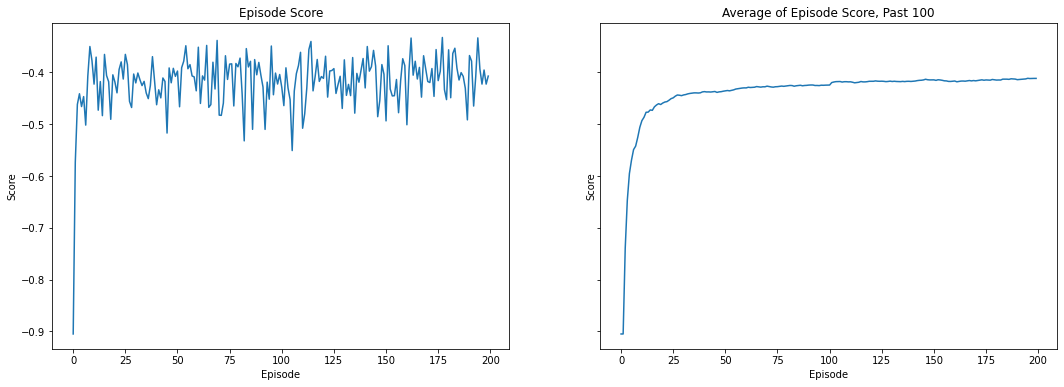

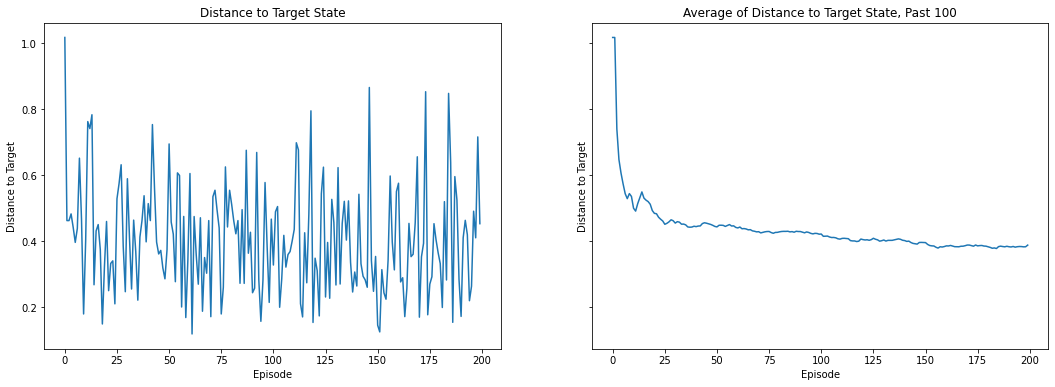

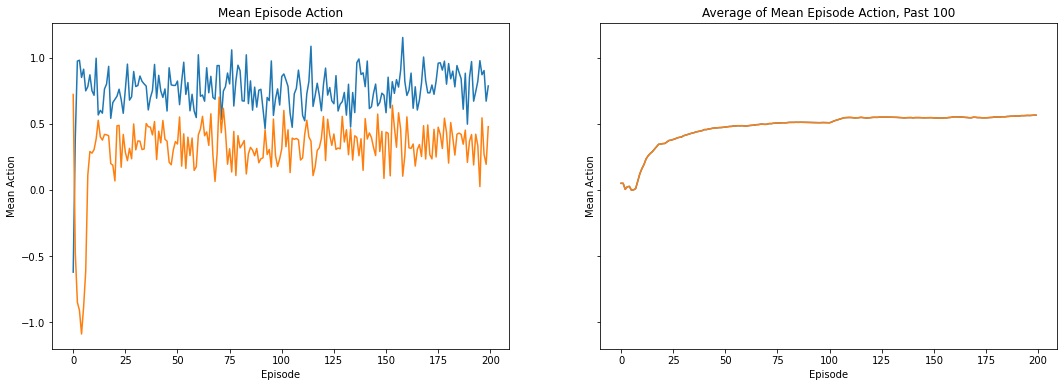

In [24]:
episode_scores
episode_distances
episode_actions

ave_episode_scores = np.zeros((episode_scores.shape))
ave_episode_distances = np.zeros((episode_distances.shape))
ave_episode_actions = np.zeros((episode_actions.shape))

for _ep in range(MAX_EPISODES):
  if _ep >= 100:
    ave_episode_scores[_ep] = np.mean(episode_scores[_ep-100:_ep])
    ave_episode_distances[_ep] = np.mean(episode_distances[_ep-100:_ep])
    ave_episode_actions[_ep] = np.mean(episode_actions[_ep-100:_ep])
  elif _ep == 0:
    ave_episode_scores[_ep] = np.mean(episode_scores[_ep])
    ave_episode_distances[_ep] = np.mean(episode_distances[_ep])
    ave_episode_actions[_ep] = np.mean(episode_actions[_ep])
  else:
    ave_episode_scores[_ep] = np.mean(episode_scores[:_ep])
    ave_episode_distances[_ep] = np.mean(episode_distances[:_ep])
    ave_episode_actions[_ep] = np.mean(episode_actions[:_ep])
  

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax1.plot(episode_scores)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.set_title('Episode Score')

ax2.plot(ave_episode_scores)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Score')
ax2.set_title('Average of Episode Score, Past 100')

fname = os.path.join(save_dir_specific, 'Episode Score')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax1.plot(episode_distances)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Distance to Target')
ax1.set_title('Distance to Target State')

ax2.plot(ave_episode_distances)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Distance to Target')
ax2.set_title('Average of Distance to Target State, Past 100')

#plt.show()

fname = os.path.join(save_dir_specific, 'Distance to Target State')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax1.plot(episode_actions)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Mean Action')
ax1.set_title('Mean Episode Action')

ax2.plot(ave_episode_actions)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Mean Action')
ax2.set_title('Average of Mean Episode Action, Past 100')

#plt.show()

fname = os.path.join(save_dir_specific, 'Episode Action')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)